In [1]:
# import libraries
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from os.path import isfile, isdir, join
import numpy as np
import pandas as pd
from datetime import datetime, date
from dateutil.relativedelta import relativedelta
from bs4 import BeautifulSoup
import re
from IPython.display import display
from zipfile import ZipFile
import pickle
import unicodedata
import pytz
from joblib import Parallel, delayed
import shutil
import difflib
import random
import math
from shutil import copyfile
import itertools
import time
from tqdm import tqdm
import collections
from collections import deque
import gc

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ndcg_score, accuracy_score

import lightgbm as lgbm
import optuna
from optuna import Trial, visualization

import matplotlib as mpl
from matplotlib import pyplot as plt

import jpx_tokyo_market_prediction

from utility_script import *

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
Notebook Parameters
'''
SEED = 0
N_STOCK_SAMPLE = 2000
N_DAY_SAMPLE = 300
N_FOLD = 5
STOCK_LIST = pd.read_csv('../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv').loc[lambda x: x.Universe0==1].SecuritiesCode.sort_values().unique().tolist()[:N_STOCK_SAMPLE]
LAGS = {'1d':1, '3d':3, '1w':5, '1m':20, '3m':20*3, '6m':20*6, '12m':20*12}
# LAGS = {'3d':3, '1w':5}
MAX_DAYS_LAG = max(list(LAGS.values()))
WIN_SIZE = 500
JPX_PATH = '../input/jpx-tokyo-stock-exchange-prediction'

In [3]:
class JPXData:
    def __init__(self, window_size, df_names):
        self.size = 0
        self.window_size = window_size
        self.df_names = df_names
        self.num_df = len(df_names)
        self.data = {df_name : pd.DataFrame() for df_name in df_names}
        self.row_counts = {df_name : [] for df_name in df_names}
        self.dates = []
        self.first_date, self.last_date = None, None
        self.features = []

        
    def push_forward(self, new_data):
        # assign names to new data assuming the same as df_names
        new_data = dict(zip(self.df_names, new_data))
        # case when no enough data
        if self.size < self.window_size:
            for df_name in self.df_names:
                self.data[df_name] = pd.concat([self.data[df_name], new_data[df_name]]).reset_index(drop=True)
                self.row_counts[df_name] = self.row_counts[df_name] + [new_data[df_name].shape[0]]
            self.dates = self.dates + [new_data[self.df_names[0]].Date.iloc[0]] 
            self.size += 1
        # general case (shift by 1 day)
        else:
            for df_name in self.df_names:
                self.data[df_name] = pd.concat([self.data[df_name].iloc[self.row_counts[df_name][0]:], new_data[df_name]]).reset_index(drop=True)
                self.row_counts[df_name] = self.row_counts[df_name][1:] + [new_data[df_name].shape[0]]
            self.dates = self.dates[1:] + [new_data[self.df_names[0]].Date.iloc[0]]  
        # update date range
        self.first_date, self.last_date = self.dates[0], self.dates[-1]
        # generate features
        if self.size == self.window_size:
            self.features.append(get_features(self.data))
        log(f'Pushed to latest date: {self.last_date}')
        
    def clear_hist_features(self):
        self.features = []

In [4]:
def standard_dist(s, lag):
    tail_data = s.tail(LAGS[lag])
    return (s.iloc[-1] - tail_data.mean()) / tail_data.std()

def ma_pctg_ch(s, lag):
    return s.iloc[-1] / s.tail(LAGS[lag]).mean() - 1

def sharpe(s, lag):
    tail_data = s.tail(LAGS[lag])
    std = tail_data.std()
    if std > 0:
        sharpe_ratio = tail_data.mean() / tail_data.std()
    else:
        sharpe_ratio = 0
    return sharpe_ratio

In [5]:
%%time

def get_features(data):
    df_prices, df_sec_prices, df_fins, df_opts, df_trades = tuple(data.values())
#     df_prices, df_sec_prices, df_fins, df_opts, df_trades = tuple(data.data.values())

    # base table
    features = df_prices.loc[lambda x: x.Date==x.Date.iloc[-1]][['RowId','Date','SecuritiesCode']]


    '''
    Major stock prices features
    '''
    # precalculate new columns
    df_prices['zero_trade'] = (df_prices.Volume==0).astype(int)
    cols = df_prices.columns.tolist()[3:]
    df_prices[cols] = df_prices.groupby('SecuritiesCode')[cols].ffill()
    df_prices['ret'] = df_prices.groupby('SecuritiesCode').Close.apply(lambda s: np.log(s).diff())
    ret_mkt = df_prices.groupby('Date').ret.mean()
    var_mkt = (ret_mkt**2).tail(LAGS['12m']).sum()
    df_prices['ret_mkt'] = df_prices.Date.map(ret_mkt)
    df_prices['spread'] = df_prices['High'] - df_prices['Low']
    df_prices['div_ratio'] = df_prices['ExpectedDividend'].fillna(0) / df_prices['Close']
    df_prices['dollar_traded'] = np.log(df_prices.Volume * (df_prices.Open + df_prices.Close)/2 + 1)
    df_prices['RS_sqrt_vol'] = np.sqrt(np.log(df_prices['High']/df_prices['Close'])*np.log(df_prices['High']/df_prices['Open']) + np.log(df_prices['Low']/df_prices['Close'])*np.log(df_prices['Low']/df_prices['Open']))
    # zero trade indicator
    features['zero_trade'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').zero_trade.last())
    # Change in Close price
    for lag in ['3d','1w']:
        features[f'price_ma_pctg_ch_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').Close.apply(lambda s: ma_pctg_ch(s, lag)))
    for lag in ['1m','3m','6m','12m']:
        features[f'price_standard_dist_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').Close.apply(lambda s: standard_dist(s, lag)))
    # Change in volume
    for lag in ['3d','1w']:
        features[f'volume_ma_pctg_ch_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').Volume.apply(lambda s: ma_pctg_ch(s, lag)))
    for lag in ['1m','3m','6m','12m']:
        features[f'volume_standard_dist_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').Volume.apply(lambda s: standard_dist(s, lag)))
    # daily spread
    for lag in ['3d','1w']:
        features[f'spread_ma_pctg_ch_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').spread.apply(lambda s: ma_pctg_ch(s, lag)))
    for lag in ['1m']:
        features[f'spread_standard_dist_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').spread.apply(lambda s: standard_dist(s, lag)))
    # volatility
    for lag in ['1w','1m','3m','12m']:
        features[f'volatility_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').ret.apply(lambda s: s.tail(LAGS[lag]).std())) 
    # change in volatility
    features['volatility_diff'] = features['volatility_1w'] - features['volatility_1m']
    # market return and volatility
    for lag in ['3d','1w','1m','3m']:
        features[f'ret_mkt_{lag}'] = ret_mkt.tail(LAGS[lag]).sum()
        features[f'vol_mkt_{lag}'] = ret_mkt.tail(LAGS[lag]).std()
    # beta
    df_prices['beta'] = df_prices.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').apply(lambda df: (df.set_index('Date').ret * ret_mkt).tail(LAGS['12m']).sum() / var_mkt))
    features['beta'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode')['beta'].last())
    # excess return
    df_prices['exret'] = df_prices['ret'] - df_prices['beta'] * df_prices['ret_mkt']
    for lag in ['3d','1w','1m','3m']:
        features[f'exret_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode')['exret'].apply(lambda s: s.tail(LAGS[lag]).sum()))
    # supervision
    features['supervision'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').SupervisionFlag.apply(lambda s: s.astype(int).iloc[-1]))
    # div ratio
    features['div_ratio'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').apply(lambda df: df.ExpectedDividend.fillna(0).iloc[-1] / df.Close.tail(LAGS['1m']).mean()))
    # change in dollar value traded
    for lag in ['1w','1m']:
        features[f'dollar_standard_dist_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').dollar_traded.apply(lambda s: standard_dist(s, lag)))
    # RS_sqrt_vol
    features['RS_sqrt_vol'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').RS_sqrt_vol.last())
    # sharpe
    for lag in ['1m','3m']:
        features[f'sharpe_{lag}'] = features.SecuritiesCode.map(df_prices.groupby('SecuritiesCode').ret.apply(lambda s: sharpe(s, lag)))


    '''
    Secondary stock prices features
    '''
    # precalculate new columns
    df_sec_prices['ret'] = df_sec_prices.groupby('SecuritiesCode').Close.apply(lambda s: np.log(s).diff())
    df_sec_prices['dollar_traded'] = np.log(df_sec_prices.Volume * (df_sec_prices.Open + df_sec_prices.Close)/2 + 1)
    # cross-sectional return & volatility
    for n in [1,3]:
        features[f'sec_cross_sect_ret_{n}'] = df_sec_prices.groupby('SecuritiesCode').ret.apply(lambda s: s.tail(n).sum()).mean()
        features[f'sec_cross_sect_vol_{n}'] = df_sec_prices.groupby('SecuritiesCode').ret.apply(lambda s: s.tail(n).sum()).std()
    # Change in volume
    for lag in ['3d','1w']:
        features[f'sec_volume_ma_pctg_ch_{lag}'] = df_sec_prices.groupby('SecuritiesCode').Volume.apply(lambda s: ma_pctg_ch(s, lag)).mean()
    # volatility
    for lag in ['1w','1m','3m']:
        features[f'sec_volatility_{lag}'] = df_sec_prices.groupby('SecuritiesCode').ret.apply(lambda s: s.tail(LAGS[lag]).std()).mean()
    # change in volatility
    features['sec_volatility_diff'] = features['sec_volatility_1w'] - features['sec_volatility_1m']
    # change in dollar value traded
    for lag in ['1w','1m']:
        features[f'sec_dollar_standard_dist_{lag}'] = df_sec_prices.groupby('SecuritiesCode').dollar_traded.apply(lambda s: standard_dist(s, lag)).mean()

    '''
    Time phase features
    '''
    # day in week
    day_in_week_angle = (features.Date.dt.weekday / 5 * 2 * np.pi).iloc[-1]
    features['day_in_week_sin'] = np.sin(day_in_week_angle)
    features['day_in_week_cos'] = np.cos(day_in_week_angle)
    # day in month
    day_in_month_angle = ((features.Date.dt.day - 1) / 31 * 2 * np.pi).iloc[-1]
    features['day_in_month_sin'] = np.sin(day_in_month_angle)
    features['day_in_month_cos'] = np.cos(day_in_month_angle)
    # week in year
    week_in_year_angle = ((features.Date.dt.week - 1) / 52 * 2 * np.pi).iloc[-1]
    features['week_in_year_sin'] = np.sin(week_in_year_angle)
    features['week_in_year_cos'] = np.cos(week_in_year_angle)


    '''
    Financials features
    '''
    # convert string to numbers
    fin_cols = ['NetSales','OperatingProfit','OrdinaryProfit','Profit','EarningsPerShare','TotalAssets','Equity','EquityToAssetRatio','BookValuePerShare']
    df_fins[fin_cols] = df_fins[fin_cols].replace('－',np.nan).astype(float)
    # drop invalid rows
    df_fins = df_fins \
        .loc[lambda x: x.NetSales > 0] \
        .sort_values(['SecuritiesCode','Date']) \
        .reset_index(drop=True)
    # compute each quarter's YoY % change
    yoy_changes = pd.concat([df_fins[['SecuritiesCode','Date','TypeOfCurrentPeriod']], df_fins.groupby(['SecuritiesCode','TypeOfCurrentPeriod'])[fin_cols].pct_change().ffill()], axis=1)
    # take last record as current feature values
    feats_fins = pd.concat([yoy_changes \
                            .loc[lambda x: x.TypeOfCurrentPeriod==q] \
                            .groupby('SecuritiesCode') \
                            .last()[fin_cols] \
                            .set_axis([f'{x}_{q}' for x in fin_cols], axis=1) 
                            for q in ['1Q','2Q','3Q','FY']], 
                           axis=1)
    features = features.merge(feats_fins, how='left', on='SecuritiesCode')
    # num days since last announcement
    features['days_since_last_fin'] = (features.Date - features.SecuritiesCode.map(yoy_changes.groupby('SecuritiesCode').Date.last())) / np.timedelta64(1,'D')


    '''
    Post-processing
    '''
    cols = [c for c in features.columns if c not in ['RowId','Date','SecuritiesCode']]
    features[cols] = features[cols].replace(np.inf, np.nan).replace(-np.inf, np.nan)
    features[cols] = features[cols].fillna(features[cols].mean())
    
    return features

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 9.3 µs


In [6]:
%%time

# initialize Data Object
data = JPXData(window_size=WIN_SIZE, df_names=['df_prices', 'df_sec_prices', 'df_fins', 'df_opts', 'df_trades'])

for folder in ['train_files', 'supplemental_files']:
# for folder in ['train_files']:
    # read all files
    df_prices = pd.read_csv(f'{JPX_PATH}/{folder}/stock_prices.csv', parse_dates=['Date'])
    df_sec_prices = pd.read_csv(f'{JPX_PATH}/{folder}/secondary_stock_prices.csv', parse_dates=['Date'])
    df_fins = pd.read_csv(f'{JPX_PATH}/{folder}/financials.csv', parse_dates=['Date'])
    df_opts = pd.read_csv(f'{JPX_PATH}/{folder}/options.csv', parse_dates=['Date'])
    df_trades = pd.read_csv(f'{JPX_PATH}/{folder}/trades.csv', parse_dates=['Date'])

    # iterate dates
    for date in df_prices.Date.sort_values().unique():
        data.push_forward([df.loc[lambda x: x.Date==date] for df in [df_prices, df_sec_prices, df_fins, df_opts, df_trades]])

    # release memory
    del df_prices, df_sec_prices, df_fins, df_opts, df_trades
    gc.collect()
    
# save FE progress
features = pd.concat(data.features).reset_index(drop=True)
save_pkl(features, 'features')
save_pkl(data, 'data')
data.clear_hist_features()
display(features.sample(5))

[2022-05-27 23:18:09] Pushed to latest date: 2017-01-04 00:00:00
[2022-05-27 23:18:10] Pushed to latest date: 2017-01-05 00:00:00
[2022-05-27 23:18:10] Pushed to latest date: 2017-01-06 00:00:00
[2022-05-27 23:18:10] Pushed to latest date: 2017-01-10 00:00:00
[2022-05-27 23:18:10] Pushed to latest date: 2017-01-11 00:00:00
[2022-05-27 23:18:10] Pushed to latest date: 2017-01-12 00:00:00
[2022-05-27 23:18:10] Pushed to latest date: 2017-01-13 00:00:00
[2022-05-27 23:18:10] Pushed to latest date: 2017-01-16 00:00:00
[2022-05-27 23:18:10] Pushed to latest date: 2017-01-17 00:00:00
[2022-05-27 23:18:10] Pushed to latest date: 2017-01-18 00:00:00
[2022-05-27 23:18:10] Pushed to latest date: 2017-01-19 00:00:00
[2022-05-27 23:18:10] Pushed to latest date: 2017-01-20 00:00:00
[2022-05-27 23:18:10] Pushed to latest date: 2017-01-23 00:00:00
[2022-05-27 23:18:10] Pushed to latest date: 2017-01-24 00:00:00
[2022-05-27 23:18:10] Pushed to latest date: 2017-01-25 00:00:00
[2022-05-27 23:18:10] Pus

,RowId,Date,SecuritiesCode,zero_trade,price_ma_pctg_ch_3d,price_ma_pctg_ch_1w,price_standard_dist_1m,price_standard_dist_3m,price_standard_dist_6m,price_standard_dist_12m,volume_ma_pctg_ch_3d,volume_ma_pctg_ch_1w,volume_standard_dist_1m,volume_standard_dist_3m,volume_standard_dist_6m,volume_standard_dist_12m,spread_ma_pctg_ch_3d,spread_ma_pctg_ch_1w,spread_standard_dist_1m,volatility_1w,volatility_1m,volatility_3m,volatility_12m,volatility_diff,ret_mkt_3d,vol_mkt_3d,ret_mkt_1w,vol_mkt_1w,ret_mkt_1m,vol_mkt_1m,ret_mkt_3m,vol_mkt_3m,beta,exret_3d,exret_1w,exret_1m,exret_3m,supervision,div_ratio,dollar_standard_dist_1w,dollar_standard_dist_1m,RS_sqrt_vol,sharpe_1m,sharpe_3m,sec_cross_sect_ret_1,sec_cross_sect_vol_1,sec_cross_sect_ret_3,sec_cross_sect_vol_3,sec_volume_ma_pctg_ch_3d,sec_volume_ma_pctg_ch_1w,sec_volatility_1w,sec_volatility_1m,sec_volatility_3m,sec_volatility_diff,sec_dollar_standard_dist_1w,sec_dollar_standard_dist_1m,day_in_week_sin,day_in_week_cos,day_in_month_sin,day_in_month_cos,week_in_year_sin,week_in_year_cos,NetSales_1Q,OperatingProfit_1Q,OrdinaryProfit_1Q,Profit_1Q,EarningsPerShare_1Q,TotalAssets_1Q,Equity_1Q,EquityToAssetRatio_1Q,BookValuePerShare_1Q,NetSales_2Q,OperatingProfit_2Q,OrdinaryProfit_2Q,Profit_2Q,EarningsPerShare_2Q,TotalAssets_2Q,Equity_2Q,EquityToAssetRatio_2Q,BookValuePerShare_2Q,NetSales_3Q,OperatingProfit_3Q,OrdinaryProfit_3Q,Profit_3Q,EarningsPerShare_3Q,TotalAssets_3Q,Equity_3Q,EquityToAssetRatio_3Q,BookValuePerShare_3Q,NetSales_FY,OperatingProfit_FY,OrdinaryProfit_FY,Profit_FY,EarningsPerShare_FY,TotalAssets_FY,Equity_FY,EquityToAssetRatio_FY,BookValuePerShare_FY,days_since_last_fin
1327896,20211021_2806,2021-10-21,2806,0,-0.001770,-0.004870,-0.674102,-1.373117,-1.850903,0.043497,-0.625000,-0.722222,-0.699200,-0.800080,-0.452589,-0.711041,0.024550,-1.000000,-0.969576,0.005813,0.007277,0.004842,0.005219,-0.001463,-0.009593,0.007899,0.011159,0.011301,-0.030450,0.011957,0.007508,0.010281,0.038223,-0.009162,-0.000958,0.002761,-0.010869,0,0.010597,-1.480522,-0.001832,0.000000,0.010974,-0.036422,-0.007610,0.026704,-0.006817,0.045212,0.037931,0.010860,0.017258,0.020400,0.021233,-0.003142,-0.014366,-0.208126,-0.587785,-0.809017,-0.790776,-0.612106,-0.970942,0.239316,-0.312094,0.000000,-0.010965,0.061224,0.061778,0.039854,0.038630,-0.001142,0.038650,0.083146,0.451546,0.385870,0.318421,0.318306,0.041248,0.035115,-0.005760,0.035113,0.051647,0.379487,0.318025,0.280467,0.280649,0.041902,0.035473,-0.006857,0.035492,0.046981,0.372414,0.323503,0.014344,0.014443,0.043941,0.038731,-0.004635,0.038767,83.0
1178702,20210701_6419,2021-07-01,6419,0,0.000409,0.001106,0.251621,0.621588,0.258071,0.034181,-0.081001,-0.028945,-0.001355,-0.310834,-0.411055,-0.183844,0.018868,-0.062500,-0.078463,0.007749,0.009845,0.013034,0.015130,-0.002096,-0.017462,0.005138,-0.004931,0.007576,-0.001813,0.008696,-0.025330,0.009221,0.986618,0.013554,0.003639,-0.002496,0.022540,0,0.021511,-0.078869,0.189701,0.007369,-0.021763,-0.003134,-0.004501,0.026248,-0.013858,0.090966,0.027933,-0.003202,0.017510,0.018596,0.020718,-0.001086,-0.031239,-0.111261,-0.587785,-0.809017,0.000000,1.000000,0.120537,-0.992709,-0.384992,-1.202395,-0.990412,-0.995733,-0.995013,-0.032290,-0.010014,0.022910,-0.010014,-0.372562,-0.920468,-0.894764,-0.931996,-0.931548,-0.039017,-0.016072,0.023864,-0.016071,-0.362630,-0.731586,-0.671513,-0.687978,-0.687739,-0.046902,-0.020414,0.027555,-0.020429,-0.345803,-0.702553,-0.642324,-0.649130,-0.649296,-0.007891,0.016680,0.025000,0.016664,45.0
702547,20200709_7487,2020-07-09,7487,0,-0.004614,-0.002773,0.425991,-0.982193,-0.096771,-0.288018,0.543408,0.713062,-0.108967,-0.352921,-0.301556,-0.140549,0.144330,0.114458,-0.125336,0.007418,0.021499,0.016696,0.018931,-0.014080,-0.016978,0.003774,0.010749,0.011745,-0.035194,0.014925,0.101115,0.013504,0.625234,0.004838,0.007282,0.009911,-0.117897,0,0.011092,1.440847,0.238214,0.015042,-0.028126,-0.054581,-0.009793,0.034479,-0.005994,0.056163,0.042024,0.005860,0.023709,0.028446,0.03

CPU times: user 4h 28min 19s, sys: 16min 3s, total: 4h 44min 22s
Wall time: 4h 44min 17s


In [7]:
# correlation plot
corr = features.iloc[:,3:].corr()
corr.style.background_gradient(cmap='coolwarm')

<AxesSubplot:xlabel='Date'>

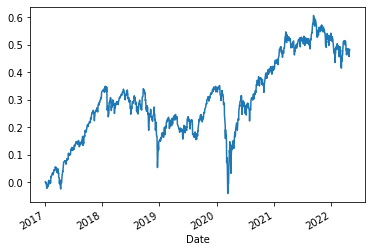

In [8]:
# for folder in ['train_files', 'supplemental_files']:
# for folder in ['train_files']:
    # read all files
df_prices = pd.concat([pd.read_csv(f'{JPX_PATH}/{folder}/stock_prices.csv', parse_dates=['Date']) for folder in ['train_files', 'supplemental_files']]).reset_index(drop=True)
df_prices.groupby('Date').Target.mean().cumsum().plot()